In [23]:
import numpy as np
from numpy.linalg import inv as inv
from scipy.linalg import solve_continuous_are
from scipy.linalg import solve_discrete_are
import matplotlib.pyplot as plt
import cvxpy as cp
import time

DIM = 1

In [92]:
# Computer K and P_t-1 for standard LQR controller
def lqr(A, B, Q, R, P):
    K = -1 * inv(B.T @ P @ B + R) @ B.T @ P @ A
    Ptm1 = A.T @ P @ A + (B.T @ P @ A).T @ K + Q
    return K, Ptm1

# Compute terms when we are trying to be robust to estimation error
def dist_lqr(A, B, Q, R, S, P, lam):
    I = np.eye(DIM)
    G = inv(Q + A.T@P@A - lam*S)@A@P
    M = inv(Q + A.T@P@A - lam*S)@(Q + A.T@P@A)
    Qp = G.T@Q@G + (I-A@G).T@P@(I-A@G)
    Ap = I - M
    Qpp = G.T@Q - (I-A@G).T@P@A
    
    K = inv(B.T@Qp@B + R) @ B.T@Qpp@Ap 
    Ptm1 = (Ap-G@B@K).T@Q@(Ap-G@M@K) + K.T@R@K + ((A-A@M)-(I-A@G)@B@K).T@P@((A-A@M)-(I-A@G)@B@K)
    
    return K, Ptm1, G, M

def forward(x, A, B, Q, R, S, P, d_max, lam=100):
    if d_max == 0:
        K, Ptm1,_,_ = dist_lqr(A, B, Q, R, S, P, lam=10e10)
        return K, Ptm1, x
    I = np.eye(DIM)
    
    while(True):
        print(lam, "iter")
        K, Ptml, G, M = dist_lqr(A, B, Q, R, S, P, lam)
        xhat = inv(I - G@B@K - M)@x
        d = get_opt_dist(xhat, K@xhat, A, B, Q, R, S, P, d_max)
        if lam*d.T@S@d - d_max < 0:
            lam *= 0.75 * lam
        else:
            break
    lam /= 0.75
    K, Ptml,G, M = dist_lqr(A, B, Q, R, S, P, lam)
    xhat = (I - G@B@K - M)@x
    return K, Ptml, xhat

    
def get_dist_lambda(xhat, K, A, B, Q, R, S, P, d_max, lam):
    if d_max == 0:
        return 0
    
    dist = inv(Q + A.T@P@A - lam*S) @ (A.T@P@B@K@xhat + (Q + A.T@Q@A)@xhat)
    return dist
    
def get_opt_dist(xhat, u, A, B, Q, R, S, P, d_max):
    if d_max == 0:
        return 0
    
    M = Q + A.T@P@A
    q = -2*(xhat.T@Q + (A@xhat + B@u).T@P@A)
    
    r = xhat.T@Q@xhat + u.T@R@u + (A@xhat + B@u).T@P@(A@xhat + B@u)
    Q0 = np.block([[M, q.T],[q, r]])
    Q1 = np.block([[S,np.zeros(q.T.shape)],[np.zeros(q.shape),-d_max]])
    t = cp.Variable()
    l = cp.Variable()
    T = np.block([[np.zeros(S.shape),np.zeros(q.T.shape)],[np.zeros(q.shape),1]])
    
    opt = cp.Minimize(t)
    c1 = l >= 0
    c2 = Q0 << l*Q1 + t*T
    prob = cp.Problem(opt, [c1, c2])
    prob.solve()
    
    lam = l.value
    dist = inv(Q + A.T@P@A - lam*S) @ (A.T@P@B@u + (Q + A.T@Q@A)@xhat)
    return dist

In [93]:
# Loss
J_lqr = lambda x,u,A,B,Q,R,P: (x.T@Q@x + u.T@R@u + (A@x + B@u).T@P@(A@x + B@u))[0][0]

# Standard LQR with disturbance
def run_lqr(x, A, B, Q, R, S, n_steps=5, d_max=1, rnd=False, method='standard'):
    '''
    x: starting position
    S: paramterization of ellipse, S is PD
    d_max: disturbance within a ball of radius d_max 
    vd_lam: lagrange multiplier for Vd constraint equation
    '''
    lam = 1
    # Compute P_t for each t assuming P_T = Q
    Ps = [Q]
    Ks = [np.zeros(Ps[0].shape)]
    for i in range(n_steps-1):
        if method == 'standard':
            K, Ptm1 = lqr(A, B, Q, R, Ps[-1])
        elif method == 'robust_to_est_error':
            # lam = 
            _, Ptm1, _, _ = dist_lqr(A, B, Q, R, S, Ps[-1], lam)
        Ps.append(Ptm1)
            
    # flip around so P[t] = P_t
    Ps = Ps[::-1] 
    
    cost = []
    noise = 0
    for i in range(n_steps):
        if method == 'standard':
            K, P = lqr(A, B, Q, R, Ps[i])
            xhat = x  # cheating  # _,_,xhat = forward(x, A, B, Q, R, S, P, d_max)
        else:
            # lam = 1
            # K, P, _, _ = dist_lqr(A, B, Q, R, S, Ps[i], lam)
            K, P, xhat = forward(x, A, B, Q, R, S, Ps[i], d_max)

        u = K@xhat
        if rnd:
            noise = 2*d_max*(np.random.random(x.shape) - 0.5)
        else:
            noise = get_opt_dist(xhat, u, A, B, Q, R, S, P, d_max)
        x = xhat - noise 
        
        cost.append(J_lqr(x,u,A,B,Q,R,P))
        
        # Update location
        x = A@(xhat-noise) + B@u

    return cost

In [94]:
Q = np.eye(DIM)
R = np.eye(DIM) 
A = np.random.normal(0,1,(DIM,DIM))
B = np.random.normal(0,1,(DIM,DIM))
S = np.eye(DIM) 

100 iter
100 iter
100 iter
100 iter
100 iter
100 iter
100 iter
100 iter
100 iter
100 iter
100 iter
100 iter
100 iter
100 iter
100 iter
100 iter
100 iter
100 iter
100 iter
100 iter


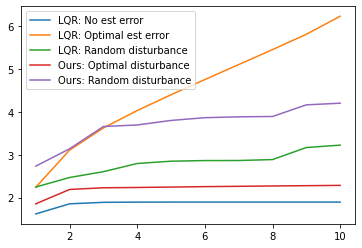

In [95]:
# Starting position, goal at 0
A = np.array([[1]])
B = np.array([[1]])
x = [[1]] # ,[1]]

n_steps = 10
d_max = 0.3 # Maximum disturbance

# Standard LQR, d_max = 0
no_dist_y = run_lqr(np.array(x), A, B, Q, R, S, n_steps=n_steps, d_max=0, method='standard')
# Standard LQR with optimal estimation error, d_max = d_max
opt_dist_y = run_lqr(np.array(x), A, B, Q, R, S, n_steps=n_steps, d_max=d_max, rnd=False, method='standard')
# Standard LQR with random estimation error, d_max = d_max
rnd_dist_y = run_lqr(np.array(x), A, B, Q, R, S, n_steps=n_steps, d_max=d_max, rnd=True, method='standard')

# Our thing
opt_dist_y_opt = run_lqr(np.array(x), A, B, Q, R, S, n_steps=n_steps, d_max=d_max, rnd=False, method='robust_to_est_error')
# Our thing
rnd_dist_y_opt = run_lqr(np.array(x), A, B, Q, R, S, n_steps=n_steps, d_max=d_max, rnd=True, method='robust_to_est_error')

x = [i for i in range(1,n_steps+1)]

plt.figure()
plt.plot(x, np.cumsum(no_dist_y), label="LQR: No est error")
plt.plot(x, np.cumsum(opt_dist_y), label="LQR: Optimal est error")
plt.plot(x, np.cumsum(rnd_dist_y), label="LQR: Random disturbance")
plt.plot(x, np.cumsum(opt_dist_y_opt), label="Ours: Optimal disturbance")
plt.plot(x, np.cumsum(rnd_dist_y_opt), label="Ours: Random disturbance")

plt.legend()
plt.show()